In [1]:

import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.interpolate import griddata
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)



pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


cuda:0


In [2]:
global temp_list
temp_list = []
Agent_number_n=3;
Alpha = 0.665 

# Hyper Parameters
echo = 2001 
BATCH_SIZE = 64
LR_G = 0.001           # learning rate for generator
LR_D = 0.001           # learning rate for discriminator
N_IDEAS = Agent_number_n             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = Agent_number_n     # it could be total point G can draw in the canvas

Is_GAN = True # if use Gan

def Generate_distribution(Agent_number_n):
    return sorted(np.random.rand(Agent_number_n), reverse=True)
    #return sorted(np.random.normal(normalloc,normalscale,Agent_number_n))

In [3]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function_label(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h

def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    h_list = []
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
        
        h = h_function_label(temp)
        h_list.append(float(h))
    temp_list = np.array(temp_list)
    x_list = np.array(x_list)
    return temp_list,S,x_list,h_list
    

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    temp_list = np.array(temp_list)
    return temp_list,S
    

def read_testing_data():
    for i in range(10000):
        appen_test(Generate_distribution(Agent_number_n));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
print(testing_data)
print(testing_label)

[[[0.45490768 0.18211338]
  [0.88543285 0.18211338]
  [0.88543285 0.45490768]]

 [[0.30521299 0.19970377]
  [0.9140317  0.19970377]
  [0.9140317  0.30521299]]

 [[0.29269281 0.15313246]
  [0.32783487 0.15313246]
  [0.32783487 0.29269281]]

 ...

 [[0.29872785 0.26080495]
  [0.63492416 0.26080495]
  [0.63492416 0.29872785]]

 [[0.95768969 0.87279238]
  [0.97381397 0.87279238]
  [0.97381397 0.95768969]]

 [[0.19337406 0.09798505]
  [0.89121234 0.09798505]
  [0.89121234 0.19337406]]]
[1.52245391 1.41894846 1.         ... 1.19445697 2.80429604 1.18257145]


In [4]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        
        self.input_dim = (Agent_number_n-1)
        self.hidden_dim = 128
        self.output_dim = 1
        self.hidden_layer_count = 6 
        
        current_dim = self.input_dim
        self.layers = torch.nn.ModuleList()
        for i in range(self.hidden_layer_count):
            self.layers.append(torch.nn.Linear(current_dim, self.hidden_dim))
            current_dim = self.hidden_dim
        self.layers.append(torch.nn.Linear(current_dim, self.output_dim))

    def calculate(self, value_list):
        h = value_list
        LeakyReLU = torch.nn.LeakyReLU()
        for layer in self.layers:
            h = torch.relu(layer(h))
        return h

    def forward(self, input_list,input_label,list_x):
        global iteration,echo,target_order
        loss1 = 0
        loss2 = 0
        loss3 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)
        h_list = []

        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            h_list.append(h)
#             loss3 += torch.square(h_function_2(input_list)-h2[1])
            
        input_label = torch.from_numpy(
            np.array(input_label)).to(dev).type(torch.float32)
        sum_h = torch.sum(torch.cat(h_list)).to(dev)


        loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                        torch.square(((Agent_number_n-1)*input_label-sum_h)),
                        torch.zeros(1).to(dev)
                      )

        loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                        torch.square((sum_h-(Agent_number_n-Alpha)*input_label))/100,
                        torch.zeros(1).to(dev)
                      )


        return loss1,loss2
    
    def supervised_loss(self, input_list,label):
        global iteration,echo,target_order
        input_list = torch.from_numpy(
            np.array(input_list)).to(dev).type(torch.float32)
        loss = 0 
        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            loss += torch.square(h - label[i])
        return loss

In [5]:
def redistribution_value_function(input_tensor):
    S = torch.max(torch.sum(input_tensor), torch.ones(1).to(dev))
    temp_list = []


    for i in range(Agent_number_n):
        temp = []
        
        for j in range(Agent_number_n):
            if(i != j):
                temp .append(input_tensor[j])
                
        temp = torch.stack(temp)
        temp_list.append(temp)
    return torch.stack(temp_list), S

GeneratorNet = nn.Sequential(                      # Generator
    # random ideas (could from normal distribution)
    nn.Linear(N_IDEAS, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    # making a painting from these random ideas
    nn.Linear(64, ART_COMPONENTS),
    nn.Sigmoid(),
)

In [6]:
random.seed(2000)
torch.manual_seed(256)
DiscriminatorNet  = Net()
DiscriminatorNet.apply(weight_init)
GeneratorNet.apply(weight_init)
# DiscriminatorNet = torch.load("save/Deep_learning_D_4_gan")
# if(Is_GAN):
#     GeneratorNet = torch.load("save/Deep_learning_G_4)
DiscriminatorNet.to(dev)
GeneratorNet.to(dev)

opt_D = torch.optim.Adam(DiscriminatorNet.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(GeneratorNet.parameters(), lr=LR_G)


scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=100, gamma=0.98)
scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=100, gamma=0.98)

index_train_list = []
index_test_list = []
train_losses = []
test_losses = []

In [7]:
#supervised
index_supervisedtrain_list = []
supervisedtrain_losses = []
for iteration in range(int(echo)):

    temp_number = 0
    total_batch_loss = 0 
    
    loss_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_S, training_data,label = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss = DiscriminatorNet.supervised_loss(training_data_i, label)
        denominator += 1
        loss_sum += h_loss

    loss_sum = torch.sum(loss_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss += float(loss_sum)

    opt_D.zero_grad()
    loss.backward()
    opt_D.step()

    if (iteration%100 == 0):
        print(iteration,loss,total_batch_loss)
        index_supervisedtrain_list.append(iteration)
        supervisedtrain_losses.append(total_batch_loss)
    scheduler_D.step()

0 tensor(3.3856, device='cuda:0', grad_fn=<DivBackward0>) 216.67645263671875
100 tensor(0.0129, device='cuda:0', grad_fn=<DivBackward0>) 0.8248920440673828
200 tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 0.02073778584599495
300 tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 0.013134494423866272
400 tensor(8.1025e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.005185612011700869
500 tensor(5.6058e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.00358771113678813
600 tensor(2.4066e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0015402056742459536
700 tensor(1.5114e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0009672854212112725
800 tensor(1.5443e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0009883682942017913
900 tensor(1.3798e-05, device='cuda:0', grad_fn=<DivBackward0>) 0.0008830970036797225
1000 tensor(7.6077e-06, device='cuda:0', grad_fn=<DivBackward0>) 0.0004868949472438544
1100 tensor(5.5585e-06, device='cuda:0', grad_fn=<DivBackward0>) 0.0003557438321877

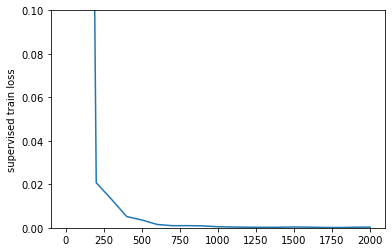

In [8]:
plt.ylim(0, 0.1)
plt.plot(index_supervisedtrain_list ,supervisedtrain_losses)
plt.ylabel('supervised train loss')

plt.show()

In [9]:
for iteration in range(int(echo)):

    temp_number = 0
    total_batch_loss = 0 
        
    loss2_list = []
    loss1_sum = 0
    loss2_sum = 0
    denominator = 0
    for index in range(0, BATCH_SIZE):
        training_data_i, training_label, training_data, label = appen_train(
            Generate_distribution(Agent_number_n))
        h_loss1, h_loss2 = DiscriminatorNet(training_data_i, training_label,
                                       training_data)
        denominator += 1
        loss1_sum += h_loss1
        loss2_sum += h_loss2

    loss_sum = torch.sum(loss1_sum + loss2_sum)
    loss = (loss_sum) / denominator 
    total_batch_loss +=float(loss_sum)

    opt_D.zero_grad()
    loss.backward()
    opt_D.step()

    temp_number = iteration
    index_train_list.append(iteration)
    train_losses.append(total_batch_loss)

    if (iteration%100 == 0):
        print(temp_number,loss,float(loss1_sum),float(loss2_sum))
    ## Gan 
        if(Is_GAN):## Gan Work traning GeneratorNet

            DiscriminatorNet.requires_grad = True
            GeneratorNet.requires_grad = True


            for step in range(100):
                # real painting from artist
                G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                      requires_grad=True).to(dev)  # random ideas\n
                # fake painting from G (random ideas)

                G_values = GeneratorNet(G_ideas)
                G_values , indices = torch.sort(G_values, descending=True)
            #     print(artist_paintings)
            #     print(G_paintings)

                result_list = []
                for index in range(BATCH_SIZE):
                    h_list = []
                    value_list_tensor, S_tensor = redistribution_value_function(
                        G_values[index])
                    for i in range(Agent_number_n):
                        h = DiscriminatorNet.calculate(
                            value_list_tensor[i].cuda().type(torch.float32))
                        h_list.append(h)
                    h_list = torch.stack(h_list)
                    result_list.append(torch.sum(h_list)/S_tensor.cuda())
                result_list = torch.stack(result_list)

                diff_loss = torch.max(result_list)-torch.min(result_list)
                G_loss = torch.max(- diff_loss)

                opt_G.zero_grad()
                G_loss.backward()
                opt_G.step()

            # real painting from artist
                G_ideas = torch.randn(BATCH_SIZE, N_IDEAS,
                                      requires_grad=True).to(dev)  # random ideas\n
                # fake painting from G (random ideas)

                G_values = GeneratorNet(G_ideas)
                G_values , indices = torch.sort(G_values, descending=True)
            #     print(artist_paintings)
            #     print(G_paintings)

                result_list = []
                for index in range(BATCH_SIZE):
                    h_list = []
                    value_list_tensor, S_tensor = redistribution_value_function(
                        G_values[index])
                    for i in range(Agent_number_n):
                        h = DiscriminatorNet.calculate(
                            value_list_tensor[i].cuda().type(torch.float32))
                        h_list.append(h)
                    h_list = torch.stack(h_list)
                    result_list.append(torch.sum(h_list)/S_tensor.cuda())
                result_list = torch.stack(result_list)

                diff_loss = torch.max(result_list)-torch.min(result_list)

                D_loss = torch.where((Agent_number_n-1)>torch.min(result_list),
                    torch.square(((Agent_number_n-1)-torch.min(result_list))),
                    torch.zeros(1).to(dev)
                  )   + torch.where((Agent_number_n-Alpha)<torch.max(result_list),
                                torch.square((torch.max(result_list)-(Agent_number_n-Alpha)))/10000,
                                torch.zeros(1).to(dev)
                              )


                opt_D.zero_grad()
                D_loss.backward()
                opt_D.step()
                
            print("Gan:",G_loss,D_loss)
            print()

            
        result_list = []
        for index in range(len(testing_data)):
            h_list = []
            for i in range(Agent_number_n):
                h = DiscriminatorNet.calculate(
                    torch.tensor(testing_data[index][i]).to(dev).type(
                        torch.float32))
                h_list.append(float(h))
            result_list.append(sum(h_list) / testing_label[index])
        print(max(result_list), min(result_list),
              max(result_list) - min(result_list),
              (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )

        index_test_list.append(iteration)
        test_losses.append(
            (sum(result_list) / len(result_list) - min(result_list))+ Agent_number_n-1 - min(min(result_list),Agent_number_n-1) )
        print()
        index_test_list.append(iteration)
        test_losses.append(
            max(result_list)-min(result_list) )
        
  
        print()


    scheduler_D.step()
    scheduler_G.step()

0 tensor(0., device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
Gan: tensor(-0.2471, device='cuda:0', grad_fn=<MaxBackward1>) tensor([6.3996e-08], device='cuda:0', grad_fn=<AddBackward0>)

2.6034767031669617 2.1060510172833884 0.4974256858835733 0.1572802979127519


100 tensor(3.5545e-08, device='cuda:0', grad_fn=<DivBackward0>) 0.0 2.274864527862519e-06
Gan: tensor(-0.3295, device='cuda:0', grad_fn=<MaxBackward1>) tensor([5.1429e-09], device='cuda:0', grad_fn=<AddBackward0>)

2.4079304933547974 1.9984211325645447 0.4095093607902527 0.14361825572955844


200 tensor(2.4032e-08, device='cuda:0', grad_fn=<DivBackward0>) 0.0 1.53803296143451e-06
Gan: tensor(-0.3329, device='cuda:0', grad_fn=<MaxBackward1>) tensor([1.1401e-09], device='cuda:0', grad_fn=<AddBackward0>)

2.4049012660980225 2.003865361213684 0.4010359048843384 0.13022650316871376


300 tensor(0., device='cuda:0', grad_fn=<DivBackward0>) 0.0 0.0
Gan: tensor(-0.3273, device='cuda:0', grad_fn=<MaxBackward1>) tensor([1.1603e-08], de

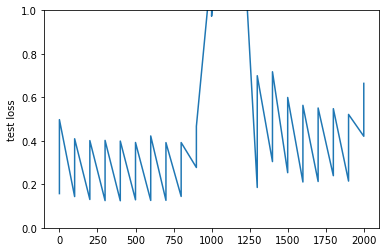

In [10]:
plt.ylim(0, 1.0)
plt.plot(index_test_list,test_losses)
plt.ylabel('test loss')

plt.show()

In [11]:
torch.save(DiscriminatorNet, "save/Deep_learning_D_3_gan")
if(Is_GAN):
    torch.save(GeneratorNet, "save/Deep_learning_G_3")

In [12]:
def h_3_star(a, b, t):
    return a - min(a, t) + b - min(b, t) + max(min(a, t)+min(b, t), 2*t/3) + 1/2 * max(min(a, t)+min(b, t), t) - 1/2 * max(max(min(a, t), min(b, t)), 2*t/3) - t/6


def f_function(a, b, z):
    if(z >= 1):
        return (a+b)/2 + z/3
    else:
        return z/3 + h_3_star(a, b, 1-z)/2

def h_function(input_list):
    #input_list = sorted(input_list)
    g_list = []
    for j1 in range(len(input_list) ):
        for j2 in range(len(input_list)):
            if(j1 != j2):
                a = input_list[j1]
                b = input_list[j2]
                z = sum(input_list)- a-b

                g_list.append( f_function(a, b, z) * (Agent_number_n-1))
    h = sum(g_list) * 3 /  (Agent_number_n) /  (Agent_number_n-1) /  (Agent_number_n - 2)
    return h
                
                
x_list = []
y_list = []
z_list = []
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        x_list.append(testing_data[index][i][0])
        y_list.append(testing_data[index][i][1])
        h = h_function(testing_data[index][i])
        z_list.append(float(h))
        h_list.append(float(h))
    result_list.append(sum(h_list)/testing_label[index]) 
    
    
print(max(result_list), min(result_list), max(result_list)-min(result_list),sum(result_list)/len(result_list))

2.333303122229241 2.0 0.33330312222924086 2.1035264688532704


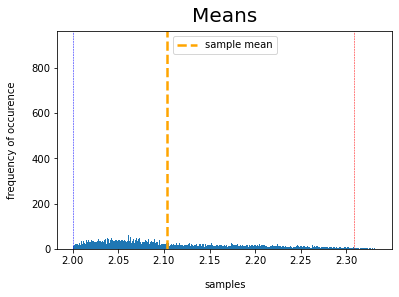

In [13]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [14]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = DiscriminatorNet.calculate(torch.tensor(testing_data[index][i]).to(dev).type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list))
print(sum(result_list)/len(result_list))

2.590037213480692 1.9257894158363342 0.6642477976443577
2.2725116997338204


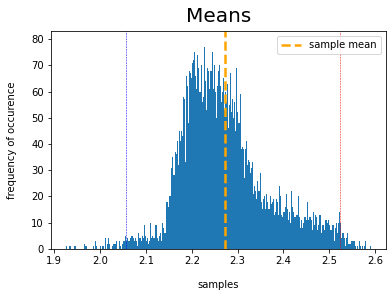

In [15]:
plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [16]:
#Generate 10000 testing data on GeneratorNet

In [17]:
def appen_test_G(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data_G.append(temp_list)
    testing_label_G.append(S)
# fake painting from G (random ideas)

def read_testing_data_G():
    for i in range(10000):
        #appen_test_G(sorted(np.random.rand(Agent_number_n), reverse=True));
        G_ideas = torch.randn(N_IDEAS).to(dev)  # random ideas\n
        G_values = GeneratorNet(G_ideas)
        G_values , indices = torch.sort(G_values, descending=True)
        appen_test_G(G_values.detach().cpu().numpy()) 
        
testing_data_G = []
testing_label_G = []
read_testing_data_G()
testing_data_G=np.array(testing_data_G)
testing_label_G=np.array(testing_label_G)
print(testing_data_G)
print(testing_label_G)

[[[1.07316542e-02 1.28218275e-03]
  [9.99999046e-01 1.28218275e-03]
  [9.99999046e-01 1.07316542e-02]]

 [[1.82910234e-01 2.53819656e-02]
  [9.99524355e-01 2.53819656e-02]
  [9.99524355e-01 1.82910234e-01]]

 [[2.18967209e-03 2.31463200e-04]
  [1.00000000e+00 2.31463200e-04]
  [1.00000000e+00 2.18967209e-03]]

 ...

 [[2.91213393e-02 6.71729166e-03]
  [9.99973416e-01 6.71729166e-03]
  [9.99973416e-01 2.91213393e-02]]

 [[4.73392189e-01 1.25182485e-02]
  [9.99963999e-01 1.25182485e-02]
  [9.99963999e-01 4.73392189e-01]]

 [[5.86238146e-01 5.52173192e-03]
  [9.99994516e-01 5.52173192e-03]
  [9.99994516e-01 5.86238146e-01]]]
[1.01201288 1.20781655 1.00242114 ... 1.03581205 1.48587444 1.59175439]


In [18]:
result_list_G = []
for index in range(len(testing_data_G)):
    h_list = []
    for i in range(Agent_number_n):
        h = DiscriminatorNet.calculate(torch.tensor(testing_data_G[index][i]).to(dev).type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list_G.append(sum(h_list)/testing_label_G[index])
    

print(max(result_list_G),min(result_list_G),max(result_list_G)-min(result_list_G))
print(sum(result_list_G)/len(result_list_G))

2.6126617475182123 2.1421085572336636 0.4705531902845488
2.3972802838348035


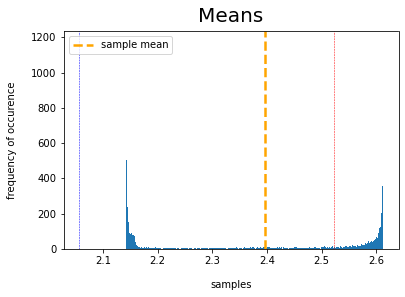

In [19]:
plt.hist(result_list_G,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list_G)/len(result_list_G), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list_G.sort()

plt.axvline(x=result_list[int(len(result_list_G)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list_G)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

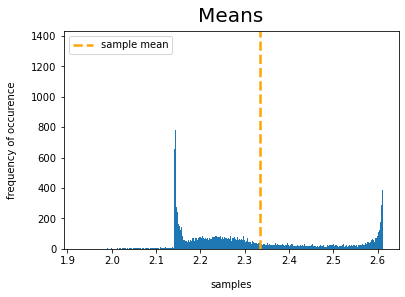

In [20]:
final_list = result_list + result_list_G


plt.hist(final_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(final_list)/len(final_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();


plt.show()